# Load packages

In [1]:
import os
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import skimage.io

from collections import defaultdict
from tqdm.auto import tqdm
from joblib import Parallel, delayed
import re
import tifffile as tiff
import pickle

import networkx as nx
from sklearn.model_selection import train_test_split

import torch_geometric.utils
import torch

c:\Users\thu71\AppData\Local\anaconda3\envs\torch\Lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\thu71\AppData\Local\anaconda3\envs\torch\Lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
c:\Users\thu71\AppData\Local\anaconda3\envs\torch\Lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
p_dir = (Path().cwd().parents[0]).absolute()

module_path = str(p_dir / "src")

if module_path not in sys.path:
    sys.path.append(module_path)

In [4]:
data_dir = (Path().cwd().parents[0] / 'data').absolute()

In [5]:
import graph
import torch
import torch_geometric.utils
import networkx as nx
import lightning.pytorch as pl
import torch.utils.data as data

spatial_omics_folder = (Path().cwd().parents[0]).absolute() / 'data' / 'spatial_omics_graph'
process_path = (Path().cwd().parents[0]).absolute() / 'data' / 'torch_graph_data'

c:\Users\thu71\AppData\Local\anaconda3\envs\torch\Lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


In [6]:
def visualize_graph(G, pos, color, figsize=(15,15), **kwargs):
    fig, ax = plt.subplots(figsize=figsize)
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(G, pos=pos, with_labels=False, 
                     node_color=color, ax=ax, **kwargs)
    ax.axis('equal')
    ax.invert_yaxis()
    ax.set_facecolor('k')
    plt.show()

## Read data Frame

In [7]:
import scanpy as sc
import anndata as ad 
# # Import spatial omics library
import athena as ath
from spatialOmics import SpatialOmics

import networkx as nx
import matplotlib 

# Save data
save_path = (Path().cwd().parents[0]).absolute() / 'data' / 'adata'

# adata_combined = ad.read_h5ad(save_path / 'all.h5ad')
adata_foll = ad.read_h5ad(save_path / 'foll.h5ad')
name_map =  { '1':'B-cell', '7':'FDC',  '0': 'Ki67+ B-cell', '4': 'Ki67+', '18': 'FDC', '8':'Other',  '11':'Macrophage',  '6':'Macrophage', '6':'Macrophage', '3':'Plasma Cell', '13':'Other','5': 'Ki67+ Macrophage',}

adata_foll.obs['name'] = (
    adata_foll.obs["merged"]
    .map(lambda x: name_map.get(x, x))
    .astype("category")
)

adata_foll.uns["name_colors"] = sc.pl.palettes.vega_20_scanpy[:len(np.unique(adata_foll.obs['name']))]

# Extract node class and colors
var = 'name'
sc.tl.dendrogram(adata_foll, 'name')
cluster_label_order = adata_foll.uns[f'dendrogram_{var}']['categories_ordered']

colors = adata_foll.uns[f"{var}_colors"]
labels = adata_foll.obs[var].cat.categories.tolist()

colors_rgb = []
for color in colors:
    colors_rgb.append(matplotlib.colors.hex2color(color))
colors_rgb = np.array(colors_rgb) * 255
colors_rgb = colors_rgb.astype(np.uint8)

colors_rgb_dict = {k:v for k,v in zip(labels, colors_rgb)}

df_cell_info = adata_foll.obs.copy()


c:\Users\thu71\AppData\Local\anaconda3\envs\torch\Lib\site-packages\scanpy\tools\_dendrogram.py:105: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(adata.obs[group]):
c:\Users\thu71\AppData\Local\anaconda3\envs\torch\Lib\site-packages\scanpy\tools\_dendrogram.py:133: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_df = rep_df.groupby(level=0).mean()


In [8]:
# Save info data
save_path = (Path().cwd().parents[0]).absolute() / 'data' / 'metadata' / 'explaination.pkl'

# Open a file and use dump()
with open(save_path, 'rb') as file:
      
    # A new file will be created
    info = pickle.load(file)

# Get dataloader

In [9]:
import graph
import torch

from torch_geometric.loader import DataLoader
seed = torch.Generator().manual_seed(42)

name = 'NIH_pos'

# Crate dataset
dataset = graph.GraphDatasetPos(process_path / name, process_path / name / 'info.csv', 2, y_name='covid')

train_set, val_set, test_set = graph.train_test_val_split(dataset)

# Create Dataloader
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=True)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)


In [10]:
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.nc}')

Dataset: GraphDatasetPos(442):
Number of graphs: 442
Number of features: 6
Number of classes: 2


In [11]:
print(f'Train set: {len(train_set)}, val set: {len(test_set)}, val set: {len(val_set)}')

Train set: 213, val set: 176, val set: 53


# Analysis of subgraph trend accross dataset

In [35]:
def count_df(array, indices):
    n,c = np.unique(array[indices], return_counts=True)
    df = pd.DataFrame([c], columns=n)
    return df

def get_percentiles(array, percentiles= [10, 45, 55, 90]):
    # Get percentiles
    m = np.percentile(array, percentiles)
    low = np.where(array <= m[0])[0]
    high = np.where(array > m[-1])[0]
    mid = np.where((array>m[1]) & (array<=m[2]))[0]

    return low, high, mid

def get_percentiles_df(array, cell_types, percentiles= [10, 45, 55, 90]):

    low, high, mid = get_percentiles(array, percentiles=percentiles)

    # Get cell types 
    df_low = count_df(cell_types, low)
    df_mid = count_df(cell_types, mid)
    df_high = count_df(cell_types, high)

    df_all = pd.concat([df_low, df_mid, df_high])
    df_all = df_all.fillna(0)
    df_all = df_all.div(df_all.sum(1), axis=0)
    df_all['Condition'] = ['Low', 'Mid', 'High']
    return df_all

def get_node_subgraph(G, high_nodes, min_comp=4):
    nodes = np.array(list(G))

    G_high_nodes = G.subgraph(nodes[high_nodes]).copy()
    G_high_nodes.remove_nodes_from(list(nx.isolates(G_high_nodes)))
    for component in list(nx.connected_components(G_high_nodes)):
        if len(component)<min_comp:
            for node in component:
                G_high_nodes.remove_node(node)
    high_nodes = np.array(list(G_high_nodes))
    return G_high_nodes, high_nodes

def get_edge_subgraph(G, high_edges, edge_importances, min_comp=4):
    edges = list(G.edges)

    G_high_edges = G.edge_subgraph([edges[i] for i in high_edges]).copy()
    nx.set_edge_attributes(G_high_edges, 
                        values = dict(zip(list(G_high_edges.edges()), edge_importances[high_edges])), 
                            name = 'weight') # Set edge weight from edge importance
    for component in list(nx.connected_components(G_high_edges)):
        if len(component)<min_comp:
            for node in component:
                G_high_edges.remove_node(node)
    high_nodes_edges = sorted(np.array(list(G_high_edges)))
    return G_high_edges, high_nodes_edges

def get_edge_subgraph_2(G, high_edges):

    G_high_edges = G.edge_subgraph([i for i in high_edges]).copy()
    
    return G_high_edges

def get_percentiles_df_edges(array, cell_types, G, percentiles= [10, 45, 55, 90]):

    # Get high importance nodes subgraphs
    low_edges, high_edges, mid_edges = get_percentiles(array, percentiles=percentiles)

    # Get induced subgraph of high edges
    _, high_nodes_edges = get_edge_subgraph(G, high_edges, array)
    _, mid_nodes_edges = get_edge_subgraph(G, mid_edges, array)
    _, low_nodes_edges = get_edge_subgraph(G, low_edges, array)

    # Get cell types 
    df_low = count_df(cell_types, low_nodes_edges)
    df_mid = count_df(cell_types, mid_nodes_edges)
    df_high = count_df(cell_types, high_nodes_edges)

    df_all = pd.concat([df_low, df_mid, df_high])
    df_all = df_all.fillna(0)
    df_all = df_all.div(df_all.sum(1), axis=0)
    df_all['Condition'] = ['Low', 'Mid', 'High']
    return df_all

## Node importance

In [13]:
dfs = []
for data in tqdm(dataset):
    # Get dataset and foll number
    dataset_name, foll = data.name.split('\\')[-1][3:-3].split('_')

    # print(dataset_name, foll)

    ########
    ### Read information

    # Get node info dataframe
    df_cell_info_foll = df_cell_info[(df_cell_info.Foll == int(foll)) & (df_cell_info.Dataset == dataset_name)]

    # Get spdata
    path = spatial_omics_folder / f'07_{dataset_name}.hdf5'
    spadata = SpatialOmics.from_h5py(path)

    # Assign node type
    spadata.obs[str(foll)]['name'] = df_cell_info_foll.name.tolist()

    # Get graph information
    G = spadata.G[str(foll)]['contact']
    data_graph = torch_geometric.utils.from_networkx(spadata.G[str(foll)]['contact'])
    G_new =  torch_geometric.utils.to_networkx(data, to_undirected=True)
    G_new.remove_edges_from(nx.selfloop_edges(G_new))
    pos = spadata.obs[str(foll)][['x','y']].loc[np.array(G.nodes())].to_numpy()
    cell_types =  spadata.obs[str(foll)]['name'].loc[np.array(G.nodes())].to_numpy()
    node_colors = tuple(colors_rgb_dict[n]/255 for n in cell_types)

    #########
    ### Get information
    info_foll = info[dataset_name + '_' + foll]
    edge_importances = info_foll['edge']
    node_importances = info_foll['node']

    ### Extract low, mid, high important nodes
    df = get_percentiles_df(node_importances, cell_types)
    df['Dataset'] = dataset_name
    df['Foll'] = foll
    dfs.append(df)

  0%|          | 0/442 [00:00<?, ?it/s]

In [14]:
# Covid mapping from patient id to covid. Covid = 1, Normal = 0
covid_dict = {'3': 'Negative', '5': 'Positive', '6': 'Negative', '8':'Positive',
             '11': 'Positive', '18': 'Negative', '21':'Negative', '22': 'Positive'}

df_all = pd.concat(dfs)
df_all['Covid'] = df_all.Dataset.apply(lambda x: covid_dict.get(x[1:], x))
df_all = df_all.fillna(0)

c:\Users\thu71\AppData\Local\anaconda3\envs\torch\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\thu71\AppData\Local\anaconda3\envs\torch\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\thu71\AppData\Local\anaconda3\envs\torch\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\thu71\AppData\Local\anaconda3\envs\torch\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be r

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Ki67+_Low vs. Ki67+_High: Mann-Whitney-Wilcoxon test two-sided, P_val:2.925e-20 U_stat=2.760e+04
Ki67+ B-cell_Low vs. Ki67+ B-cell_High: Mann-Whitney-Wilcoxon test two-sided, P_val:9.107e-03 U_stat=1.509e+04
Ki67+ Macrophage_Low vs. Ki67+ Macrophage_High: Mann-Whitney-Wilcoxon test two-sided, P_val:1.399e-04 U_stat=2.164e+04
Macrophage_Low vs. Macrophage_High: Mann-Whitney-Wilcoxon test two-sided, P_val:1.330e-01 U_stat=1.946e+04
Other_Low vs. Other_High: Mann-Whitney-Wilcoxon test two-sided, P_val:4.022e-04 U_stat=2.156e+04
Plasma Cell_Low vs. Plasma Cell_High: Mann-Whitney-Wilcoxon test two-sided, P_val:1.401e-03 U_stat=1.454e+04
FDC_Low vs. FDC_High: Mann-Whitney-Wilcoxon test two-sided, P_val:6.074e-05 U_stat=1.360e+04
B-cell_Low vs. B-cell_High: Mann-Whitney-Wilcoxon test two-sided, P_val:1.170e-17 U_st

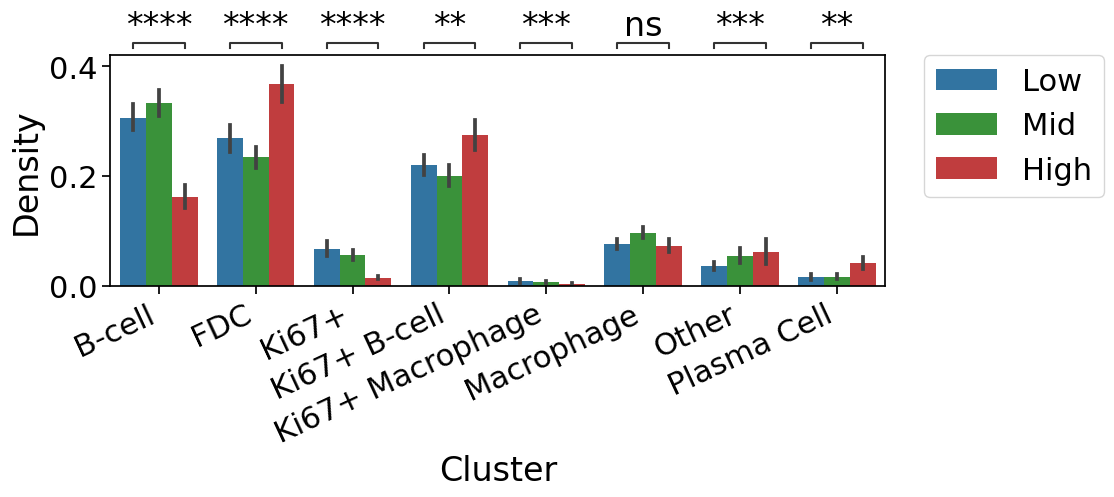

In [15]:
import seaborn as sns 
from statannotations.Annotator import Annotator

# Get data
df_subset = df_all.drop(['Foll', 'Dataset'], axis=1)
df_subset = df_subset[df_subset.Covid == 'Negative']
# df_subset = df_subset[df_subset.Condition == 'Low']
df_melt = df_subset.melt(id_vars=['Covid', 'Condition'], value_name='Density', var_name='Cluster')

# plot
x = 'Cluster'
y = 'Density'
hue = 'Condition'
with sns.plotting_context('notebook', font_scale=2):
    pairs=[((c,'Low'),(c,'High')) for c in df_melt.Cluster.unique()]
    # pairs=[((c,'Positive'),(c,'Negative')) for c in df_melt.Cluster.unique()]

    fig, ax = plt.subplots(figsize=(10,3))
    sns.barplot(data=df_melt, x=x, y=y, hue=hue, 
        palette = ['tab:blue', 'tab:green','tab:red']
        # palette = ['tab:red', 'tab:blue']
    )
    plt.xticks(rotation = 25, ha="right")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
    annotator = Annotator(ax, pairs, data=df_melt, x=x, y=y, hue=hue)
    annotator.configure(test='Mann-Whitney', text_format='star', loc='outside')
    annotator.apply_and_annotate()
    plt.show()


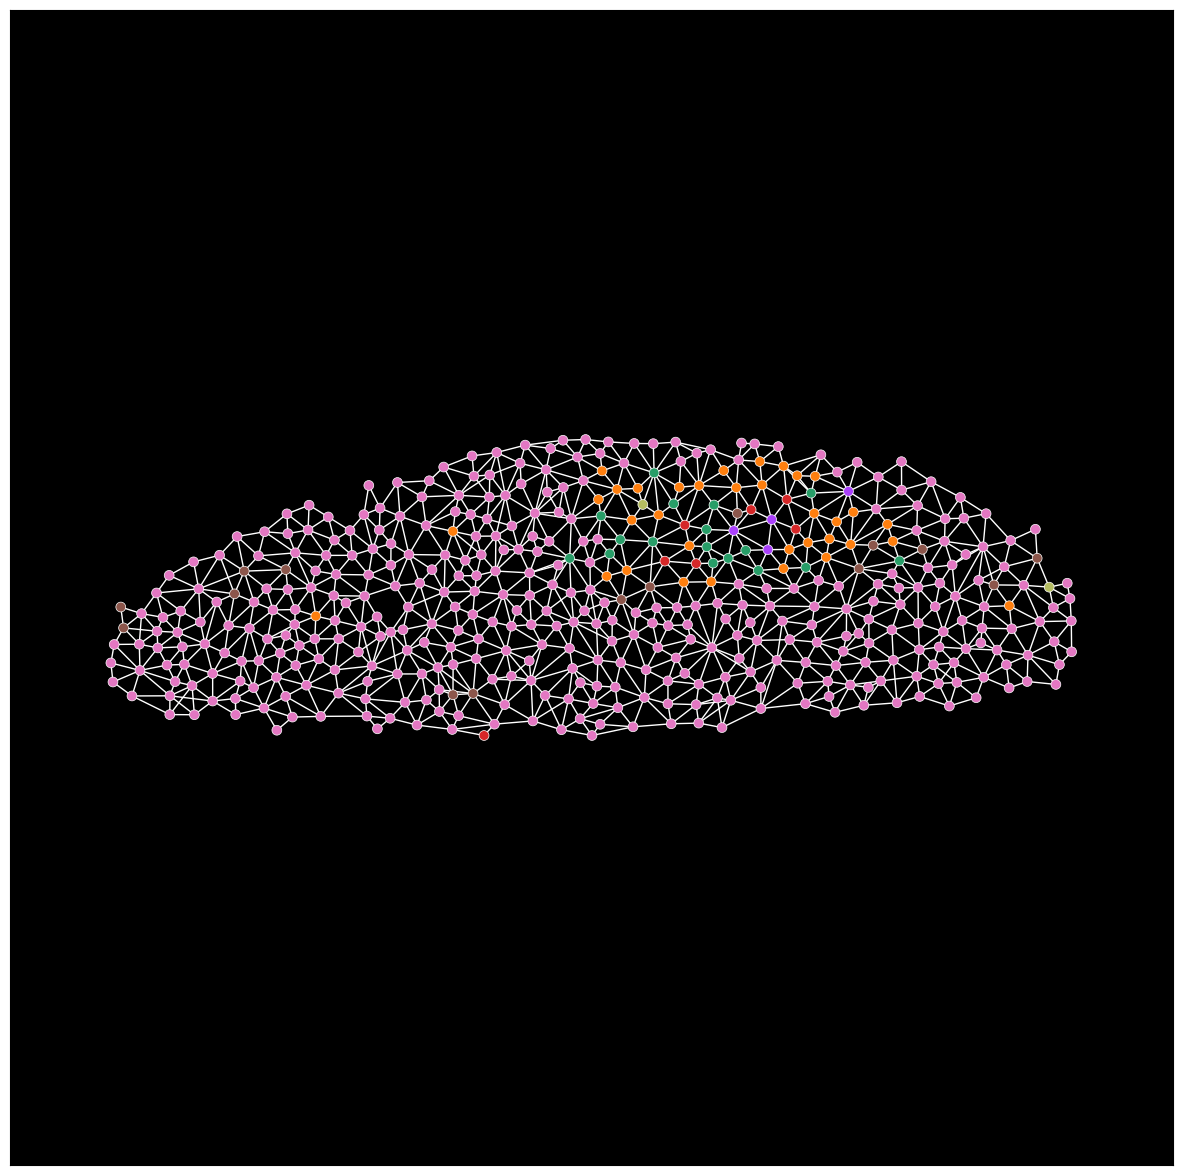

In [16]:
# Verification of extracted node order, node importance, edge importance

visualize_graph(G_new, pos, node_colors, 
    edgecolors='w',
    linewidths=0.5,
    node_size=50, 
    edge_color='w', 
    width=1, 
    arrows=False)

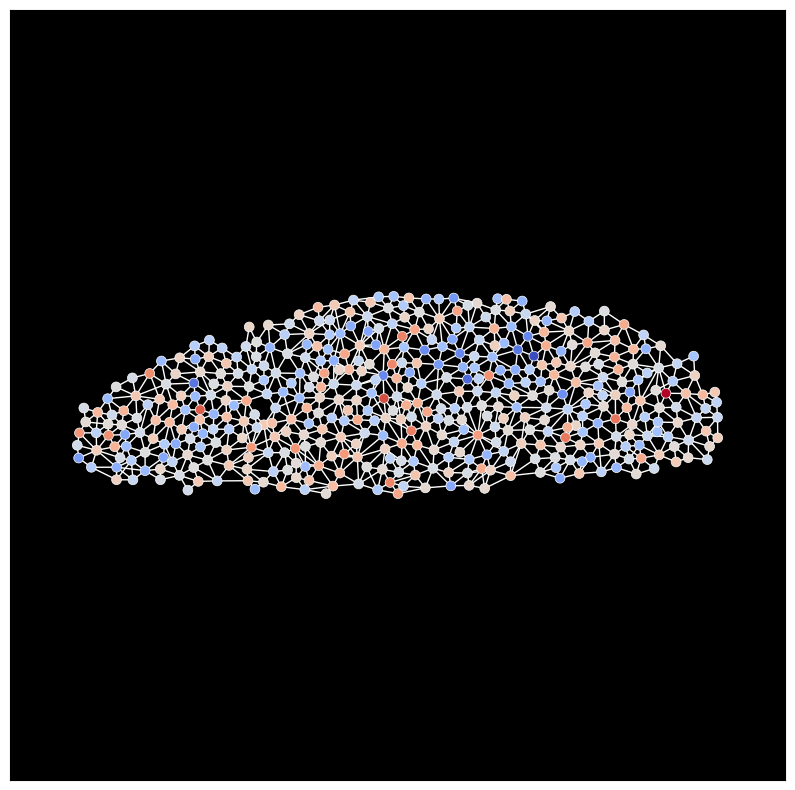

In [17]:
visualize_graph(G_new, pos, node_importances, 
    figsize=(10,10),
    edgecolors='w',
    linewidths=0.5,
    node_size=50, 
    edge_color='w', 
    cmap='coolwarm',
    arrows=False)

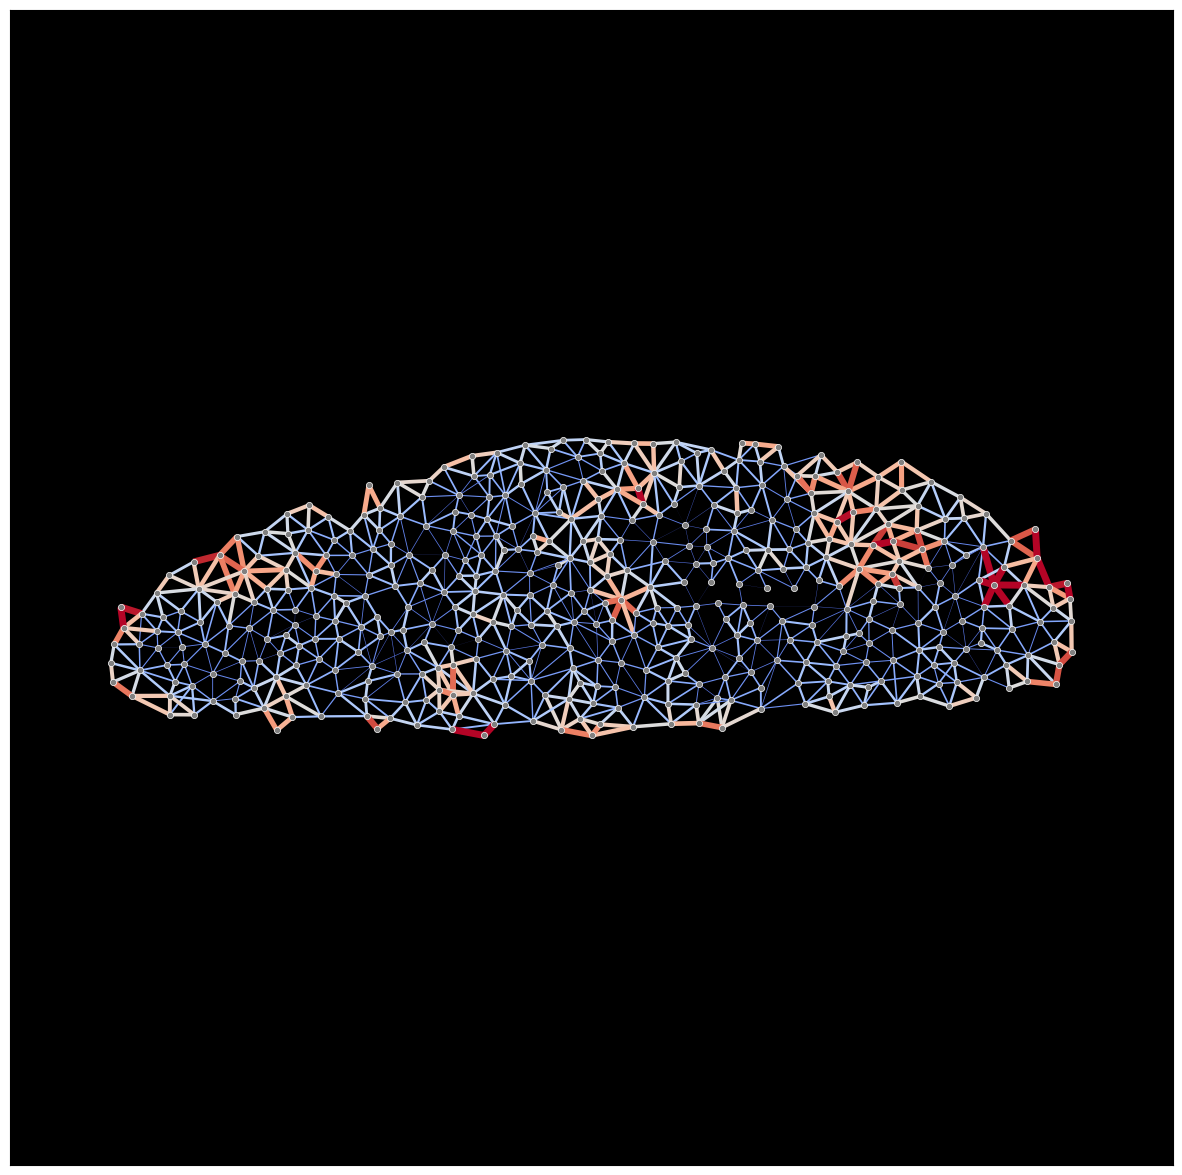

In [18]:
visualize_graph(G_new, pos, 'gray', 
    edgecolors='w',
    linewidths=0.5,
    node_size=20, 
    # edgelist=edges, 
    edge_cmap=plt.cm.coolwarm, 
    edge_color=edge_importances, 
    width=[x * 5 for x in edge_importances], 
    arrows=False)

## Edge importance

In [19]:
dfs = []
for data in tqdm(dataset):
    # Get dataset and foll number
    dataset_name, foll = data.name.split('\\')[-1][3:-3].split('_')

    # print(dataset_name, foll)

    ########
    ### Read information

    # Get node info dataframe
    df_cell_info_foll = df_cell_info[(df_cell_info.Foll == int(foll)) & (df_cell_info.Dataset == dataset_name)]

    # Get spdata
    path = spatial_omics_folder / f'07_{dataset_name}.hdf5'
    spadata = SpatialOmics.from_h5py(path)

    # Assign node type
    spadata.obs[str(foll)]['name'] = df_cell_info_foll.name.tolist()

    # Get graph information
    G = spadata.G[str(foll)]['contact']
    data_graph = torch_geometric.utils.from_networkx(spadata.G[str(foll)]['contact'])
    G_new =  torch_geometric.utils.to_networkx(data, to_undirected=True)
    G_new.remove_edges_from(nx.selfloop_edges(G_new))
    pos = spadata.obs[str(foll)][['x','y']].loc[np.array(G.nodes())].to_numpy()
    cell_types =  spadata.obs[str(foll)]['name'].loc[np.array(G.nodes())].to_numpy()
    node_colors = tuple(colors_rgb_dict[n]/255 for n in cell_types)

    #########
    ### Get information
    info_foll = info[dataset_name + '_' + foll]
    edge_importances = info_foll['edge']
    node_importances = info_foll['node']

    ### Extract low, mid, high important nodes
    df = get_percentiles_df_edges(edge_importances, cell_types, G_new)
    df['Dataset'] = dataset_name
    df['Foll'] = foll
    dfs.append(df)

  0%|          | 0/442 [00:00<?, ?it/s]

In [20]:
# Covid mapping from patient id to covid. Covid = 1, Normal = 0
covid_dict = {'3': 'Negative', '5': 'Positive', '6': 'Negative', '8':'Positive',
             '11': 'Positive', '18': 'Negative', '21':'Negative', '22': 'Positive'}

df_all = pd.concat(dfs)
df_all['Covid'] = df_all.Dataset.apply(lambda x: covid_dict.get(x[1:], x))
df_all = df_all.fillna(0)

In [21]:
df_all

B-cell       FDC  Ki67+ B-cell  Macrophage     Other  Plasma Cell  \
0   0.015251  0.915033      0.058824    0.002179  0.002179     0.006536   
0   0.559687  0.131115      0.219178    0.048924  0.000000     0.000000   
0   0.025370  0.752643      0.160677    0.061311  0.000000     0.000000   
0   0.035294  0.843137      0.070588    0.031373  0.011765     0.003922   
0   0.803797  0.063291      0.047468    0.018987  0.009494     0.000000   
..       ...       ...           ...         ...       ...          ...   
0   0.380165  0.231405      0.082645    0.016529  0.066116     0.008264   
0   0.000000  0.043478      0.115942    0.079710  0.369565     0.224638   
0   0.000000  0.088235      0.039216    0.000000  0.784314     0.000000   
0   0.000000  0.055556      0.013889    0.000000  0.861111     0.000000   
0   0.000000  0.149533      0.000000    0.121495  0.672897     0.018692   

       Ki67+  Ki67+ Macrophage Condition Dataset Foll     Covid  
0   0.000000          0.000000       Low     A11    1  Positive  
0   0.031311          0.009785       Mid     A11    1  Positive  
0   0.000000          0.000000      High     A11    1  Positive  
0   0.003922          0.000000       Low     A11    2  Positive  
0   0.053797          0.003165       Mid     A11    2  Positive  
..       ...               ...       ...     ...  ...       ...  
0   0.214876          0.000000       Mid      T8   66  Positive  
0   0.130435          0.036232      High      T8   66  Positive  
0   0.068627          0.019608       Low      T8   67  Positive  
0   0.055556          0.013889       Mid      T8   67  Positive  
0   0.028037          0.009346      High      T8   67  Positive  

[1326 rows x 12 columns]

c:\Users\thu71\AppData\Local\anaconda3\envs\torch\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\thu71\AppData\Local\anaconda3\envs\torch\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\thu71\AppData\Local\anaconda3\envs\torch\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\thu71\AppData\Local\anaconda3\envs\torch\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be r

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

FDC_Positive vs. FDC_Negative: Mann-Whitney-Wilcoxon test two-sided, P_val:4.268e-05 U_stat=1.847e+04
B-cell_Positive vs. B-cell_Negative: Mann-Whitney-Wilcoxon test two-sided, P_val:7.987e-07 U_stat=3.047e+04
Ki67+ B-cell_Positive vs. Ki67+ B-cell_Negative: Mann-Whitney-Wilcoxon test two-sided, P_val:8.170e-14 U_stat=1.399e+04
Macrophage_Positive vs. Macrophage_Negative: Mann-Whitney-Wilcoxon test two-sided, P_val:1.347e-23 U_stat=3.721e+04
Other_Positive vs. Other_Negative: Mann-Whitney-Wilcoxon test two-sided, P_val:1.333e-03 U_stat=2.800e+04
Plasma Cell_Positive vs. Plasma Cell_Negative: Mann-Whitney-Wilcoxon test two-sided, P_val:2.632e-19 U_stat=3.579e+04
Ki67+_Positive vs. Ki67+_Negative: Mann-Whitney-Wilcoxon test two-sided, P_val:1.245e-12 U_stat=3.314e+04
Ki67+ Macrophage_Positive vs. Ki67+ Macroph

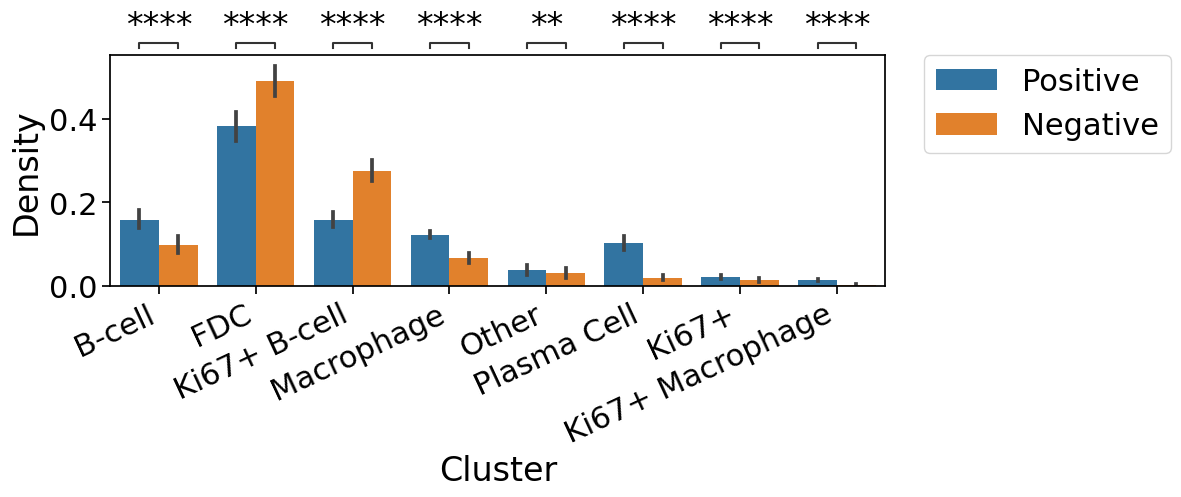

In [22]:
import seaborn as sns 
from statannotations.Annotator import Annotator

# Get data
df_subset = df_all.drop(['Foll', 'Dataset'], axis=1)
# df_subset = df_subset[df_subset.Covid == 'Positive']
df_subset = df_subset[df_subset.Condition == 'High']
df_melt = df_subset.melt(id_vars=['Covid', 'Condition'], value_name='Density', var_name='Cluster')

# plot
x = 'Cluster'
y = 'Density'
# hue = 'Condition'
hue = 'Covid'
with sns.plotting_context('notebook', font_scale=2):
    # pairs=[((c,'Low'),(c,'High')) for c in df_melt.Cluster.unique()]
    pairs=[((c,'Positive'),(c,'Negative')) for c in df_melt.Cluster.unique()]

    fig, ax = plt.subplots(figsize=(10,3))
    sns.barplot(data=df_melt, x=x, y=y, hue=hue, 
                # palette = ['tab:blue', 'tab:green','tab:red']
                )
    plt.xticks(rotation = 25, ha="right")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
    annotator = Annotator(ax, pairs, data=df_melt, x=x, y=y, hue=hue)
    annotator.configure(test='Mann-Whitney', text_format='star', loc='outside')
    annotator.apply_and_annotate()
    plt.show()


## Count interaction subraphs by Covid Status

In [23]:
dfs = []
for data in tqdm(dataset[287:]):
# for data in tqdm(dataset):
    # Get dataset and foll number
    dataset_name, foll = data.name.split('\\')[-1][3:-3].split('_')

    print(dataset_name, foll)

    ########
    ### Read information

    # Get node info dataframe
    df_cell_info_foll = df_cell_info[(df_cell_info.Foll == int(foll)) & (df_cell_info.Dataset == dataset_name)]

    # Get spdata
    path = spatial_omics_folder / f'07_{dataset_name}.hdf5'
    spadata = SpatialOmics.from_h5py(path)

    # Assign node type
    spadata.obs[str(foll)]['name'] = df_cell_info_foll.name.tolist()

    # Get graph information
    G = spadata.G[str(foll)]['contact']
    data_graph = torch_geometric.utils.from_networkx(spadata.G[str(foll)]['contact'])
    G_new =  torch_geometric.utils.to_networkx(data, to_undirected=True)
    G_new.remove_edges_from(nx.selfloop_edges(G_new))
    pos = spadata.obs[str(foll)][['x','y']].loc[np.array(G.nodes())].to_numpy()
    cell_types =  spadata.obs[str(foll)]['name'].loc[np.array(G.nodes())].to_numpy()
    node_colors = tuple(colors_rgb_dict[n]/255 for n in cell_types)

    #########
    ### Get information
    info_foll = info[dataset_name + '_' + foll]
    edge_importances = info_foll['edge']
    node_importances = info_foll['node']

    ### Extract low, mid, high important nodes
    low_edges, high_edges, mid_edges = get_percentiles(edge_importances)
    
    break

  0%|          | 0/155 [00:00<?, ?it/s]

T3 36


In [24]:
df_cell_info

ROI    Cell  Cell_ROI Dataset    Data  Foll  GC leiden merged  \
4868       2    4869      1812     A11  07_A11     5   0      6      6   
4883       2    4884      1827     A11  07_A11     5   0     18     18   
4892       2    4893      1836     A11  07_A11     5   0      1      1   
4906       2    4907      1850     A11  07_A11     5   0      7      7   
4910       2    4911      1854     A11  07_A11     5   0      7      7   
...      ...     ...       ...     ...     ...   ...  ..    ...    ...   
4725239   53  498629     10281      T8   07_T8    17   0     21      1   
4725245   53  498635     10287      T8   07_T8    17   0     21      1   
4725275   53  498665     10317      T8   07_T8    17   0     21      1   
4725284   53  498674     10326      T8   07_T8    17   0     21      1   
4725285   53  498675     10327      T8   07_T8    17   0      4      4   

               name  
4868     Macrophage  
4883            FDC  
4892         B-cell  
4906            FDC  
4910            FDC  
...             ...  
4725239      B-cell  
4725245      B-cell  
4725275      B-cell  
4725284      B-cell  
4725285       Ki67+  

[1577266 rows x 10 columns]

c:\Users\thu71\AppData\Local\anaconda3\envs\torch\Lib\site-packages\networkx\drawing\nx_pylab.py:433: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


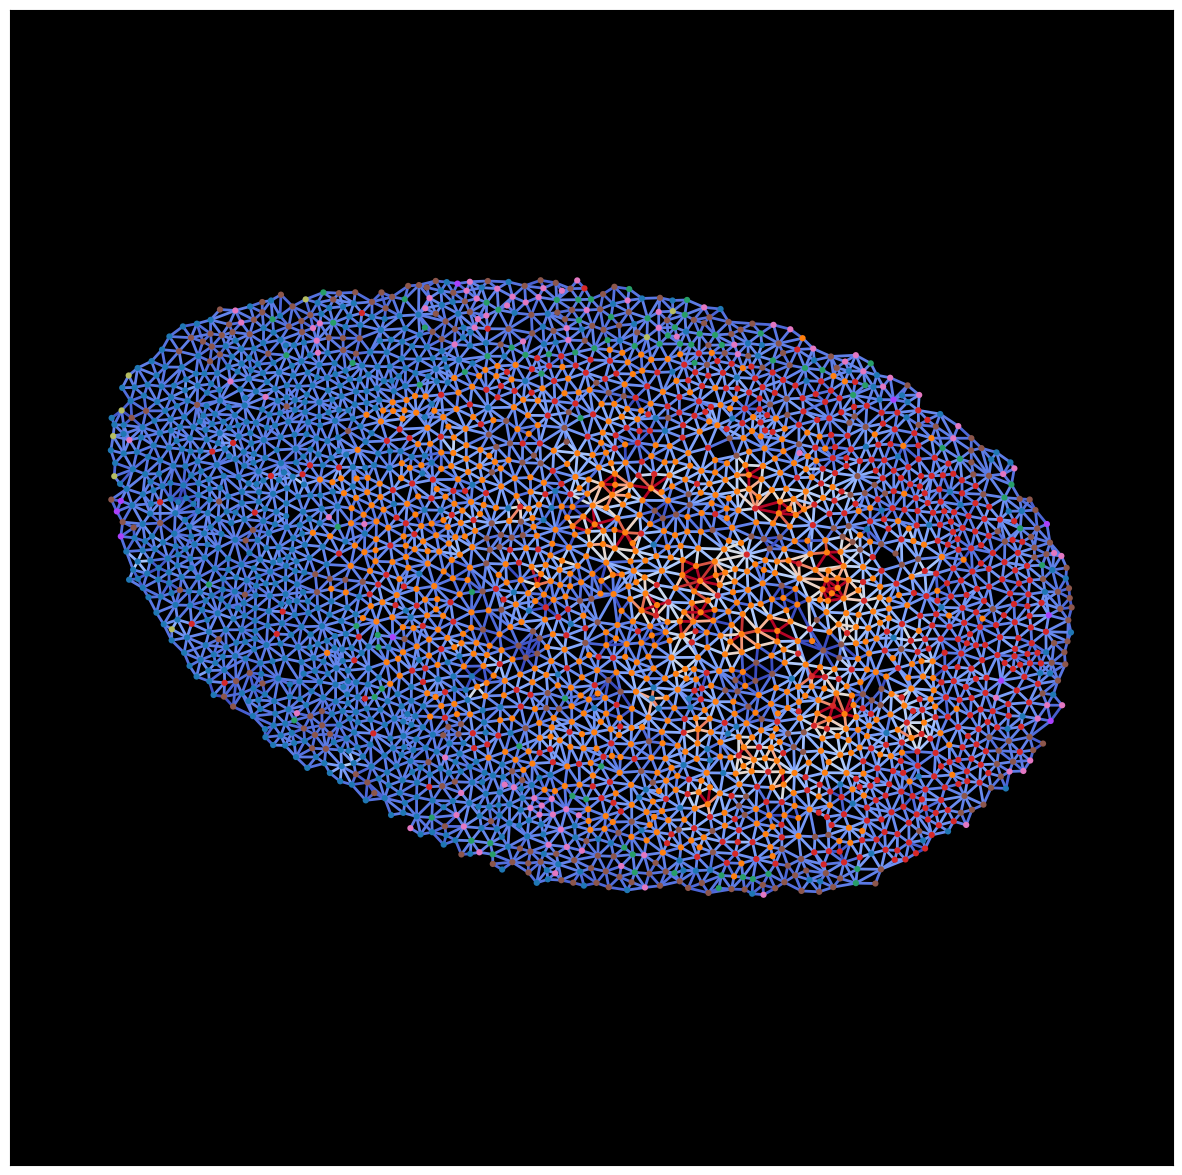

In [25]:
visualize_graph(G_new, pos, node_colors, 
    # figsize=(10,10),
    edgecolors='w',
    linewidths=0,
    node_size=20, 
    cmap='coolwarm',
    edge_cmap=plt.cm.coolwarm, 
    edge_color=edge_importances, 
    width=2,
    arrows=False)

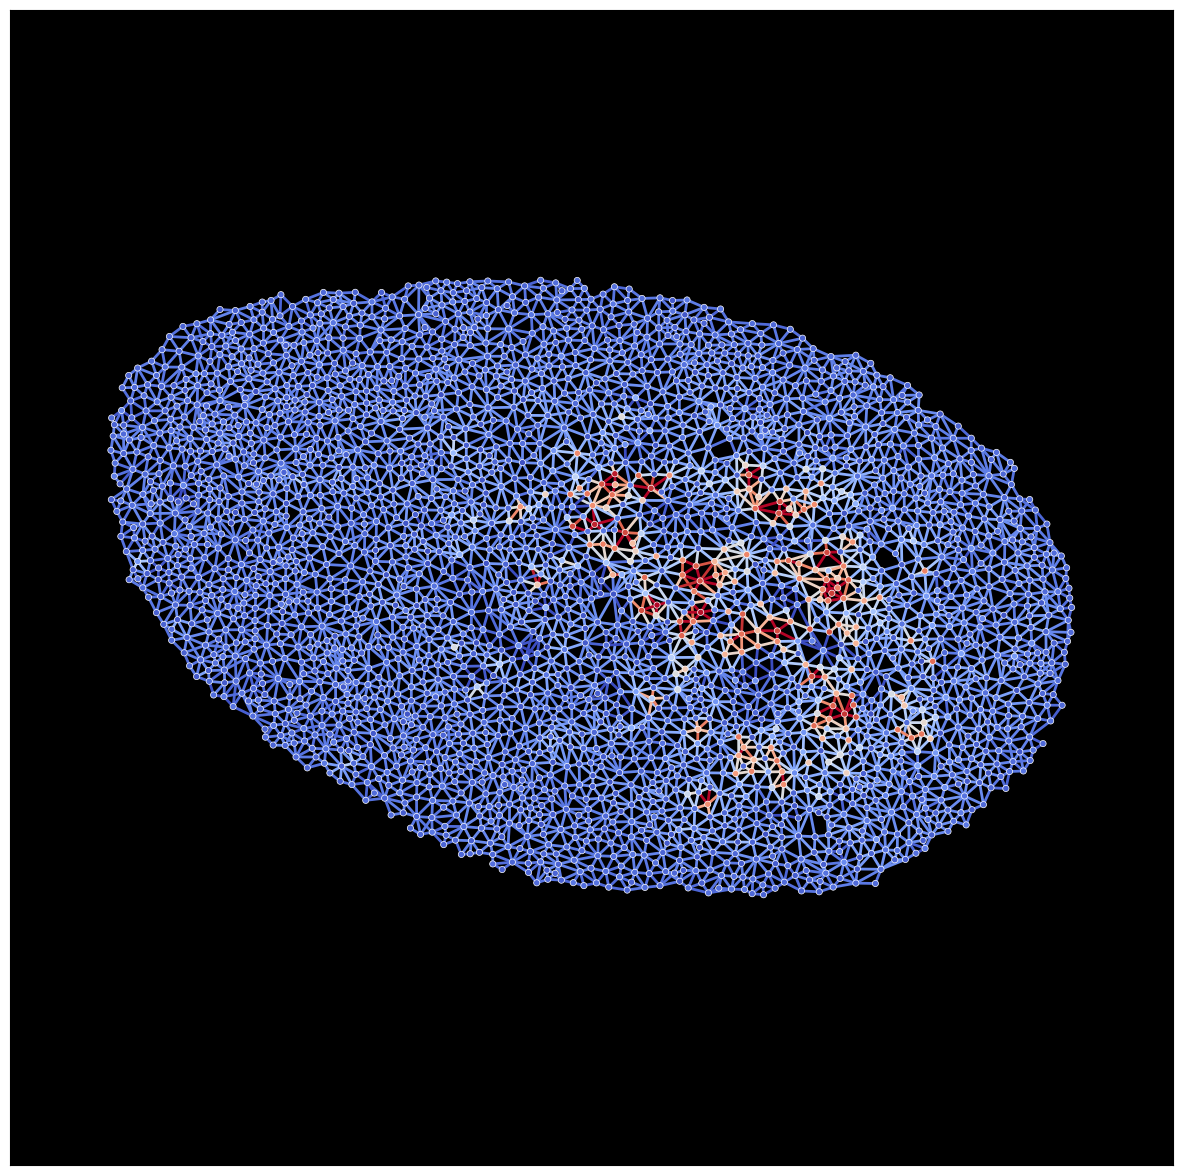

In [26]:
visualize_graph(G_new, pos, node_importances, 
    # figsize=(10,10),
    edgecolors='w',
    linewidths=0.5,
    node_size=20, 
    cmap='coolwarm',
    edge_cmap=plt.cm.coolwarm, 
    edge_color=edge_importances, 
    width=2,
    arrows=False)

In [27]:
### Extract low, mid, high important nodes
low_nodes, high_nodes, mid_nodes = get_percentiles(node_importances)
low_edges, high_edges, mid_edges = get_percentiles(edge_importances)

### Get Graph nodes and edges list and position dictionnary
pos_dict = dict(zip(np.array(list(G_new)), pos))

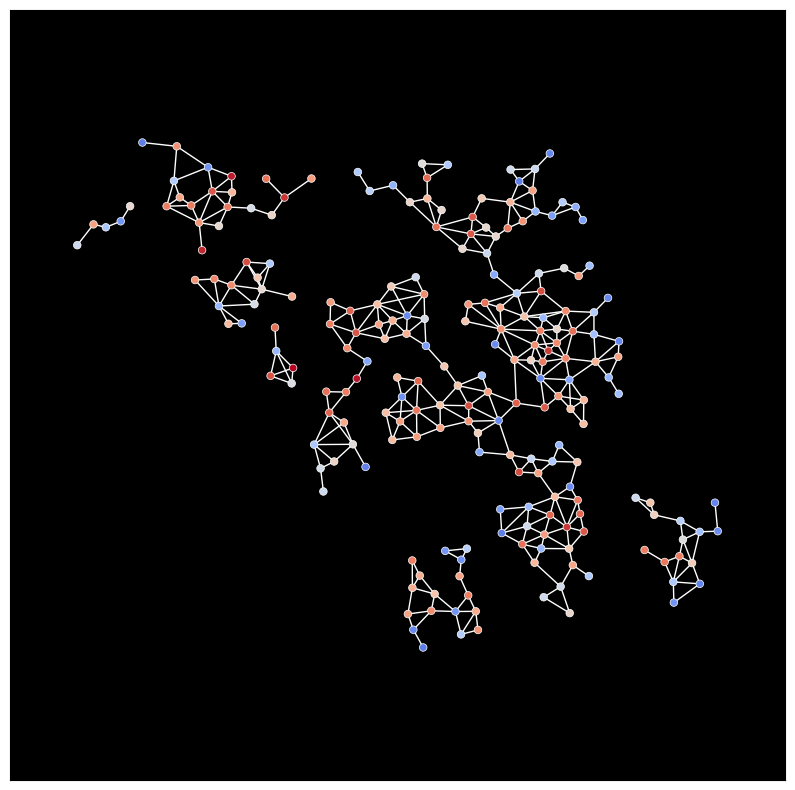

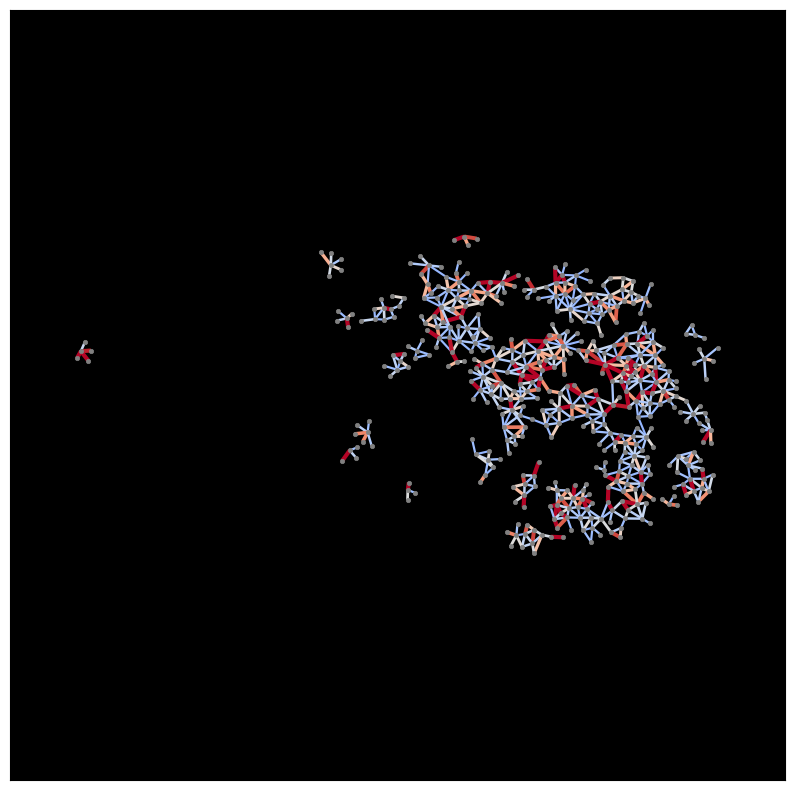

In [28]:
# Get high importance nodes subgraphs
G_high_nodes, high_nodes = get_node_subgraph(G_new, high_nodes)

# Get high importance nodes subgraphs
G_high_edges, _ = get_edge_subgraph(G_new, high_edges,  edge_importances)
weights = nx.get_edge_attributes(G_high_edges,'weight').values()

visualize_graph(G_high_nodes, pos_dict, node_importances[high_nodes], 
     figsize=(10,10),
    edgecolors='w',
    linewidths=0.5,
    node_size=30, 
    edge_color='w', 
    cmap='coolwarm',
    arrows=False,
    vmin=np.percentile(node_importances, 50),
    vmax=np.percentile(node_importances, 100)
    )

visualize_graph(G_high_edges, pos, 'gray', 
    figsize=(10,10),
    linewidths=0.5,
    node_size=10, 
    # edgelist=edges, 
    edge_cmap=plt.cm.coolwarm, 
    edge_color=weights, 
    width=[x * 2 + 1 for x in weights], 
    arrows=False,
    edge_vmin=0,
    edge_vmax=1)

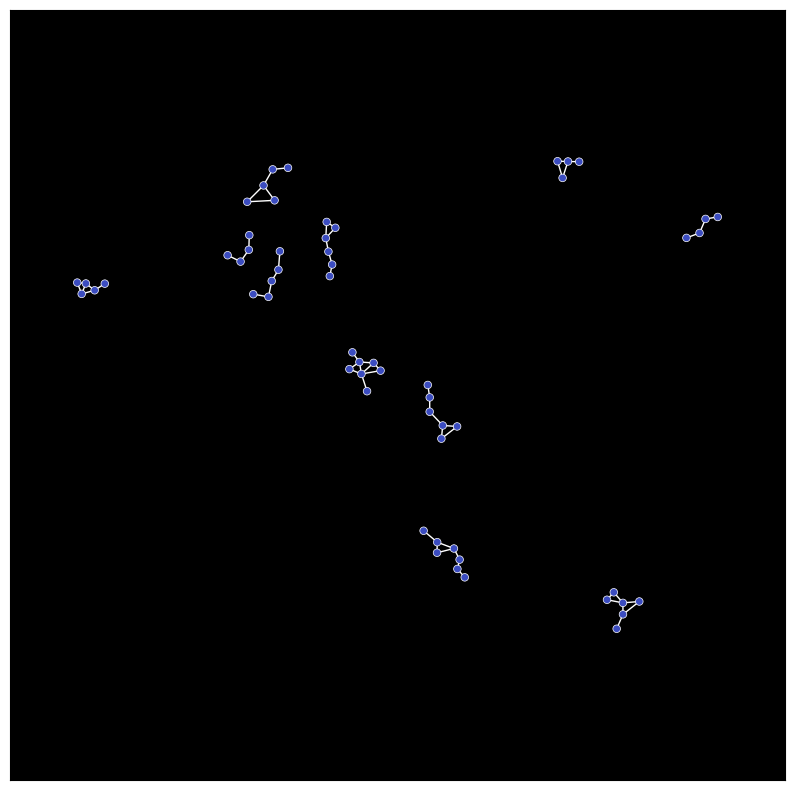

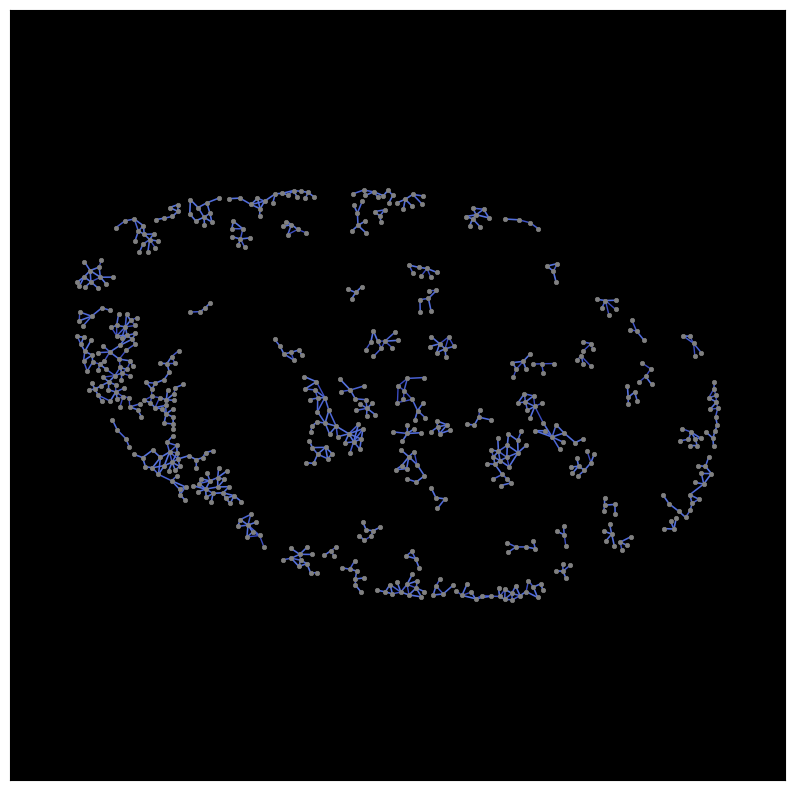

In [29]:
# Get high importance nodes subgraphs
G_high_nodes, low_nodes = get_node_subgraph(G_new, low_nodes)

# Get high importance nodes subgraphs
G_high_edges, _ = get_edge_subgraph(G_new, low_edges, edge_importances)
weights = nx.get_edge_attributes(G_high_edges,'weight').values()

visualize_graph(G_high_nodes, pos_dict, node_importances[low_nodes], 
     figsize=(10,10),
    edgecolors='w',
    linewidths=0.5,
    node_size=30, 
    edge_color='w', 
    cmap='coolwarm',
    arrows=False,
    vmin=np.percentile(node_importances, 50),
    vmax=np.percentile(node_importances, 100)
    )

visualize_graph(G_high_edges, pos, 'gray', 
    figsize=(10,10),
    linewidths=0.5,
    node_size=10, 
    # edgelist=edges, 
    edge_cmap=plt.cm.coolwarm, 
    edge_color=weights, 
    width=[x * 2 + 1 for x in weights], 
    arrows=False,
    edge_vmin=0,
    edge_vmax=1)

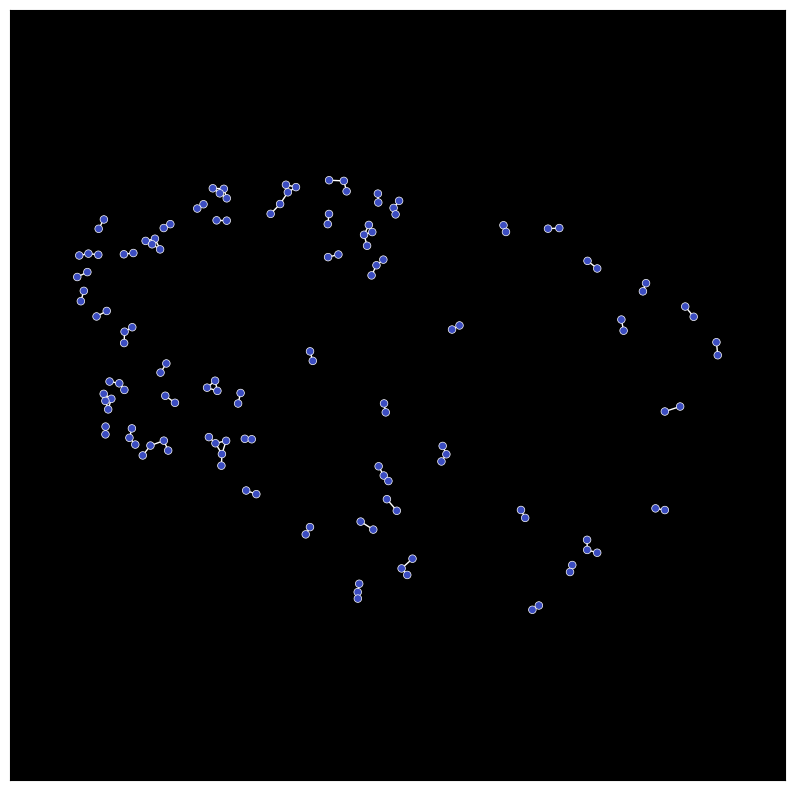

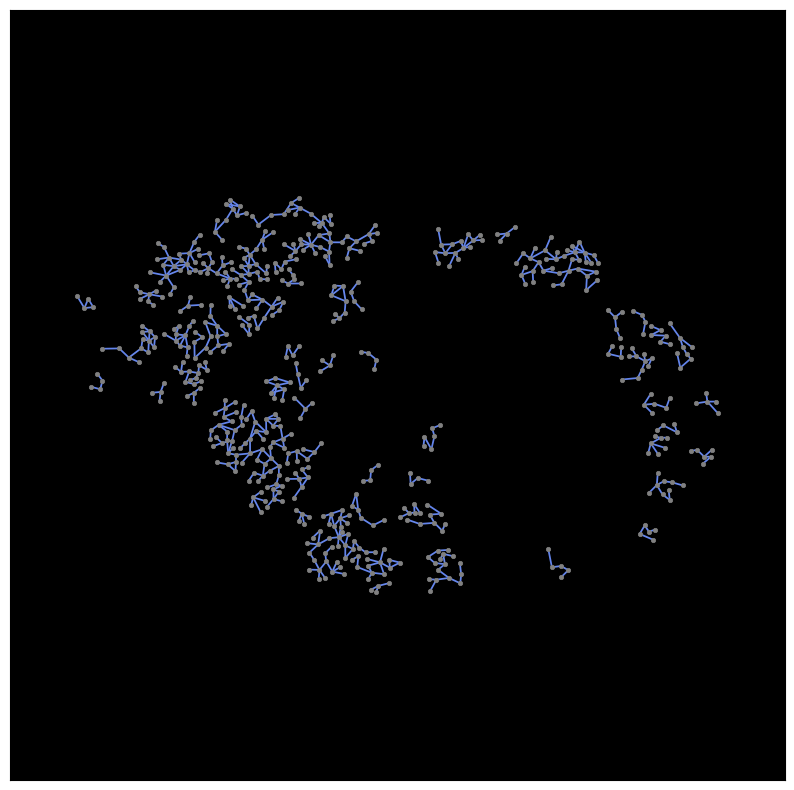

In [30]:
# Get high importance nodes subgraphs
G_high_nodes, mid_nodes = get_node_subgraph(G_new, mid_nodes, min_comp=1)

# Get high importance nodes subgraphs
G_high_edges, _ = get_edge_subgraph(G_new, mid_edges, edge_importances)
weights = nx.get_edge_attributes(G_high_edges,'weight').values()

visualize_graph(G_high_nodes, pos_dict, node_importances[mid_nodes], 
     figsize=(10,10),
    edgecolors='w',
    linewidths=0.5,
    node_size=30, 
    edge_color='w', 
    cmap='coolwarm',
    arrows=False,
    vmin=np.percentile(node_importances, 50),
    vmax=np.percentile(node_importances, 100)
    )

visualize_graph(G_high_edges, pos, 'gray', 
    figsize=(10,10),
    linewidths=0.5,
    node_size=10, 
    # edgelist=edges, 
    edge_cmap=plt.cm.coolwarm, 
    edge_color=weights, 
    width=[x * 2 + 1 for x in weights], 
    arrows=False,
    edge_vmin=0,
    edge_vmax=1)

## Plot multiplex examples

  0%|          | 0/3 [00:00<?, ?it/s]

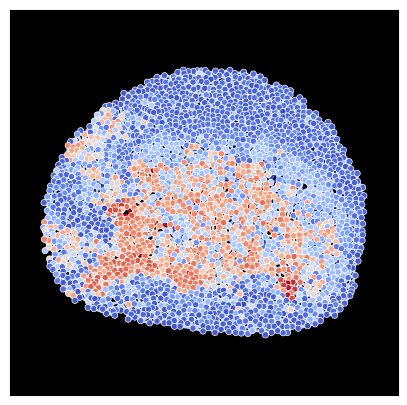

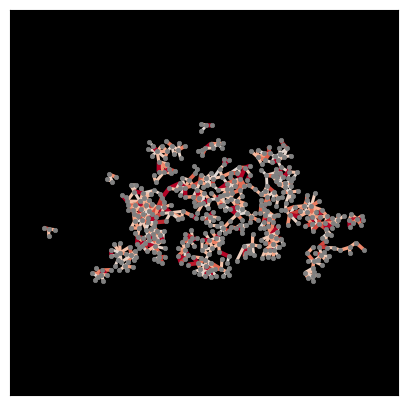

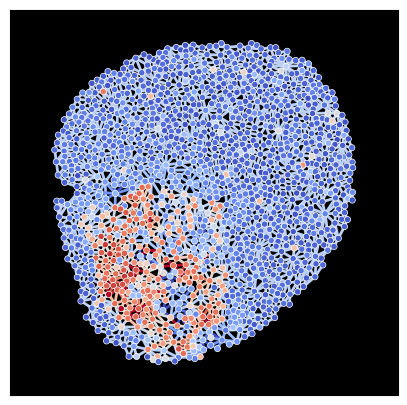

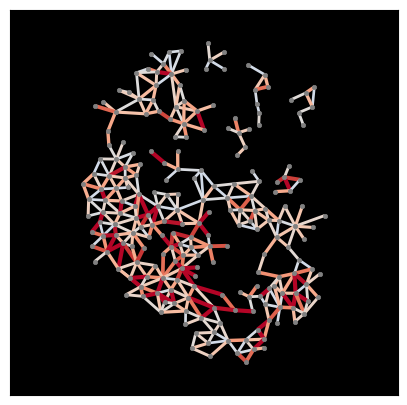

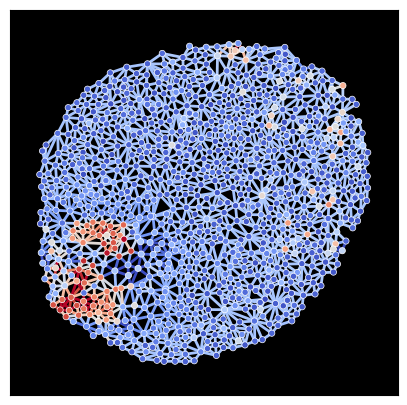

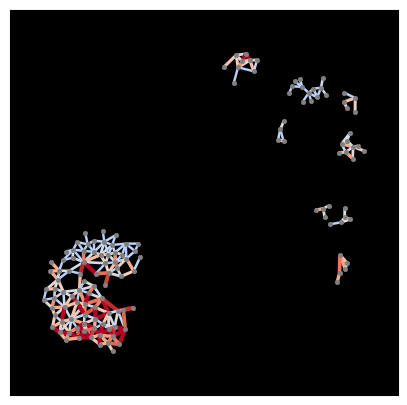

In [31]:
dfs = []
# for data in tqdm(dataset[287:]):
for data in tqdm(dataset[:3]):
    # Get dataset and foll number
    dataset_name, foll = data.name.split('\\')[-1][3:-3].split('_')

    # print(dataset_name, foll)

    ########
    ### Read information

    # Get node info dataframe
    df_cell_info_foll = df_cell_info[(df_cell_info.Foll == int(foll)) & (df_cell_info.Dataset == dataset_name)]

    # Get spdata
    path = spatial_omics_folder / f'07_{dataset_name}.hdf5'
    spadata = SpatialOmics.from_h5py(path)

    # Assign node type
    spadata.obs[str(foll)]['name'] = df_cell_info_foll.name.tolist()

    # Get graph information
    G = spadata.G[str(foll)]['contact']
    data_graph = torch_geometric.utils.from_networkx(spadata.G[str(foll)]['contact'])
    G_new =  torch_geometric.utils.to_networkx(data, to_undirected=True)
    G_new.remove_edges_from(nx.selfloop_edges(G_new))
    pos = spadata.obs[str(foll)][['x','y']].loc[np.array(G.nodes())].to_numpy()
    cell_types =  spadata.obs[str(foll)]['name'].loc[np.array(G.nodes())].to_numpy()
    node_colors = tuple(colors_rgb_dict[n]/255 for n in cell_types)

    #########
    ### Get information
    info_foll = info[dataset_name + '_' + foll]
    edge_importances = info_foll['edge']
    node_importances = info_foll['node']

    ### Extract low, mid, high important nodes
    low_edges, high_edges, mid_edges = get_percentiles(edge_importances)
    
    visualize_graph(G_new, pos, node_importances, 
    figsize=(5,5),
    edgecolors='w',
    linewidths=0.5,
    node_size=20, 
    cmap='coolwarm',
    edge_cmap=plt.cm.coolwarm, 
    edge_color=edge_importances, 
    width=2,
    arrows=False)

    ### Get Graph nodes and edges list and position dictionnary
    pos_dict = dict(zip(np.array(list(G_new)), pos))

    # # Get high importance nodes subgraphs
    # G_high_nodes, high_nodes = get_node_subgraph(G_new, high_nodes)

    # Get high importance nodes subgraphs
    G_high_edges, _ = get_edge_subgraph(G_new, high_edges, edge_importances)
    weights = nx.get_edge_attributes(G_high_edges,'weight').values()

    visualize_graph(G_high_edges, pos, 'gray', 
        figsize=(5,5),
        linewidths=0.5,
        node_size=10, 
        # edgelist=edges, 
        edge_cmap=plt.cm.coolwarm, 
        edge_color=weights, 
        width=[x * 2 + 1 for x in weights], 
        arrows=False,
        edge_vmin=0,
        edge_vmax=1)

## Analysis of subgraphs comparison

In [36]:
### Load GNN 
from graph.model import NodeLevelGNN, GraphLevelGNN, GraphLevelGNN_Moprh, GraphLevelGNN_Pos
from pytorch_lightning.utilities.model_summary import ModelSummary

# Model path
condition = '082923_Covid_pos'
checkpoint_folder = (Path().cwd().parents[0]).absolute() / 'data' / "saved_models" / f"Graph_GNNs_{condition}" 
project_name = f'SF_{condition}'

# Model parameters
NUM_LAYERS = 2
HIDDEN_CHANNELS = 16
pool = 'attention2'
model ='GAT'
fold =2
pl.seed_everything(42)

# Load model
CHECKPOINT_PATH = checkpoint_folder / f'{model}_{NUM_LAYERS}_{HIDDEN_CHANNELS}_{fold}' / pool
checkpoint = CHECKPOINT_PATH / f"GraphLevel{model}" / f"GraphLevel{model}.ckpt" 
graph_model = GraphLevelGNN_Pos.load_from_checkpoint(checkpoint, map_location=torch.device('cpu'))
graph_model.eval()

# Print model
summary = ModelSummary(graph_model)
print(summary)

Global seed set to 42


   | Name        | Type             | Params
--------------------------------------------------
0  | model       | GAT              | 5.1 K 
1  | fnn_layer   | Linear           | 272   
2  | selu        | SELU             | 0     
3  | head        | Linear           | 34    
4  | loss_module | CrossEntropyLoss | 0     
5  | train_acc   | BinaryAccuracy   | 0     
6  | train_auroc | BinaryAUROC      | 0     
7  | train_f1    | BinaryF1Score    | 0     
8  | valid_acc   | BinaryAccuracy   | 0     
9  | valid_auroc | BinaryAUROC      | 0     
10 | valid_f1    | BinaryF1Score    | 0     
11 | pool        | Attention_module | 281   
--------------------------------------------------
5.7 K     Trainable params
0         Non-trainable params
5.7 K     Total params
0.023     Total estimated model params size (MB)


In [37]:
from collections import defaultdict 

def get_embedding_edges(edges, G, model, edge_importances, min_comp = 5):
    '''
    edges: list of edges to consider for subgraph
    '''
    # Get high importance nodes subgraphs
    G_edges, _ = get_edge_subgraph(G, edges, edge_importances, min_comp=min_comp)
    
    components = []
    predictions = []
    average_IG = []
    features = []
    sub_edges = []
    for i, component in enumerate(list(nx.connected_components(G_edges))):
        data_subgraph = data.subgraph(torch.Tensor(np.array(list(component))).type(torch.long))
        prediction = model(data_subgraph.x, data_subgraph.edge_index, edge_attr=data_subgraph.edge_attr, data=data_subgraph)
        embedding = model.latent(data_subgraph.x, data_subgraph.edge_index, edge_attr=data_subgraph.edge_attr, data=data_subgraph)
        
        components.append(np.array(list(component)))
        predictions.append(prediction.cpu().detach().numpy())
        average_IG.append(np.mean(list(nx.get_edge_attributes(
                                    G_edges.subgraph(np.array(list(component))),
                                    'weight').values()))
                         )
        features.append(embedding.cpu().detach().numpy())
        sub_edges.append(G_edges.subgraph(np.array(list(component))).edges())
    return components, predictions, average_IG, features, sub_edges

In [40]:
subgraphs = defaultdict(dict)

for i, data in tqdm(enumerate(dataset), total=len(dataset)):
    # Get dataset and foll number
    dataset_name, foll = data.name.split('\\')[-1][3:-3].split('_')

    # print(dataset_name, foll)

    ########
    ### Read information

    # Get node info dataframe
    df_cell_info_foll = df_cell_info[(df_cell_info.Foll == int(foll)) & (df_cell_info.Dataset == dataset_name)]

    # Get spdata
    path = spatial_omics_folder / f'07_{dataset_name}.hdf5'
    spadata = SpatialOmics.from_h5py(path)

    # Assign node type
    spadata.obs[str(foll)]['name'] = df_cell_info_foll.name.tolist()

    # Get graph information
    G = spadata.G[str(foll)]['contact']
    data_graph = torch_geometric.utils.from_networkx(spadata.G[str(foll)]['contact'])
    G_new =  torch_geometric.utils.to_networkx(data, to_undirected=True)
    G_new.remove_edges_from(nx.selfloop_edges(G_new))
    pos = spadata.obs[str(foll)][['x','y']].loc[np.array(G.nodes())].to_numpy()
    cell_types =  spadata.obs[str(foll)]['name'].loc[np.array(G.nodes())].to_numpy()
    node_colors = tuple(colors_rgb_dict[n]/255 for n in cell_types)

    #########
    ### Get information
    pred_graph = graph_model(data.x, data.edge_index, edge_attr=data.edge_attr, data=data)
    pred_graph = pred_graph.cpu().detach().numpy()
    
    info_foll = info[dataset_name + '_' + foll]
    edge_importances = info_foll['edge']
    node_importances = info_foll['node']

    # Get prediction subgraphs
    low_edges, high_edges, mid_edges = get_percentiles(edge_importances)
    
    for n, a in list(zip(['low', 'high', 'mid'], [low_edges, high_edges, mid_edges])):
        components, predictions, average_IG, features, sub_edges = get_embedding_edges(a, G_new, graph_model, edge_importances)
        cell_t = [cell_types[c] for c in components]

        id_name = dataset_name + '_' + foll + "_" + n
        subgraphs[id_name]['graph_prediction'] = pred_graph.copy()
        subgraphs[id_name]['label'] = data.y.cpu().item()
        subgraphs[id_name]['id'] = i
        subgraphs[id_name]['components'] = components.copy()
        subgraphs[id_name]['subset_predictions'] = predictions.copy()
        subgraphs[id_name]['average_IG'] = average_IG.copy()
        subgraphs[id_name]['h'] = features.copy()
        subgraphs[id_name]['cell_type'] = cell_t.copy()
        subgraphs[id_name]['edges'] = sub_edges


  0%|          | 0/442 [00:00<?, ?it/s]

In [41]:
# Save info data
save_path = (Path().cwd().parents[0]).absolute() / 'data' / 'metadata' / 'subgraph_final.pkl'

# Open a file and use dump()
with open(save_path, 'wb') as file:
      
    # A new file will be created
    pickle.dump(subgraphs, file)

In [ ]:
print(data)

pred_graph = graph_model(data.x, data.edge_index, edge_attr=data.edge_attr, data=data)
pred_graph = pred_graph.cpu().detach().numpy()
print(pred_graph)

Data(edge_index=[2, 2992], num_nodes=446, x=[446, 6], pos=[446, 2], node_types=[446], label=0, covid=1, train_mask=[446], test_mask=[446], edge_attr=[2992, 2], y=1, name='Y:\coskun-lab\Thomas\11_snowflakes\data\torch_graph_data\NIH_pos\pt\07_T8_67.pt')
[[0.02955664 0.9704434 ]]
